In [2]:
import tensorflow as tf
import numpy as np

In [4]:
def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    
    # Create samples for each cluster
    for i in range(n_clusters):
        samples = tf.random_normal((n_samples_per_cluster, n_features),
                                   mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name="cluster_{}".format(i))
        
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        
        centroids.append(current_centroid)
        
        samples += current_centroid
        
        slices.append(samples)
        
    # Create a big "samples" dataset
    samples = tf.concat(slices, 0, name='samples')
    centroids = tf.concat(centroids, 0, name='centroids')
    return centroids, samples

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_clusters(all_samples, centroids, n_samples_per_cluster):
     
    #Plot out the different clusters
     #Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = all_samples[i*n_samples_per_cluster:(i+1)*n_samples_per_cluster]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
         #Grab just the samples fpr the given cluster and plot them out with a new colour
         #Also plot centroid
        plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()



In [10]:

n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)

In [14]:
model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    centroid_values = session.run(centroids)

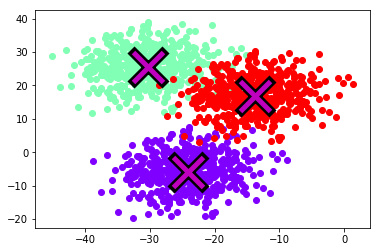

In [15]:
plot_clusters(sample_values, centroid_values, n_samples_per_cluster)

In [25]:
def choose_random_centroids(samples, n_clusters):
    # Step 0: Initialisation: Select `n_clusters` number of random points
    n_samples = tf.shape(samples)[0]
    print(n_samples)
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin = [0,]
    size = [n_clusters,]
    #size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

In [26]:
initial_centroids = choose_random_centroids(samples, n_clusters)

Tensor("strided_slice_1:0", shape=(), dtype=int32)


In [27]:
with tf.Session() as session:
    updated_centroid_value = session.run(initial_centroids)

In [19]:
updated_centroid_value

array([[-12.57284737,  16.90243149],
       [ -3.82149887,  16.00059319],
       [-36.63245392,  12.81079769]], dtype=float32)

In [24]:
sample_values

array([[-24.23473167,  -5.63619328],
       [-21.30787468,   0.05049753],
       [-29.07078743, -15.99440384],
       ..., 
       [-19.84384918,   8.68898773],
       [-12.37724876,  19.23770142],
       [-21.83363724,  21.7114563 ]], dtype=float32)

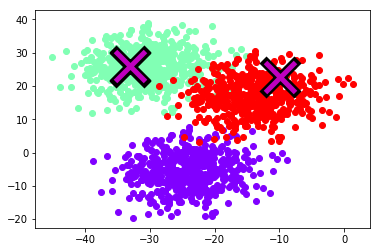

In [28]:
plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)

In [29]:
n_samples_per_cluster

500

Tensor("strided_slice_2:0", shape=(), dtype=int32)


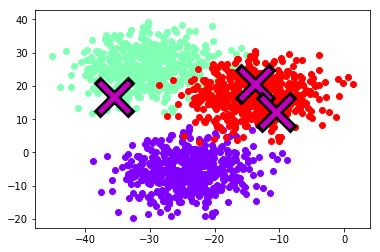

In [30]:
import tensorflow as tf
import numpy as np



n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    updated_centroid_value = session.run(initial_centroids)

plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)

In [31]:
def assign_to_nearest(samples, centroids):

    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum( tf.square(
               tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    nearest_indices = mins
    return nearest_indices
    

In [52]:
def update_centroids(samples, nearest_indices, n_clusters):
    
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return new_centroids

In [36]:
sample_values.shape

(1500, 2)

In [38]:
centroid_values.shape

(3, 2)

In [39]:
1,1500,2
3,1,2

(3, 1, 2)

In [40]:
a32 = np.array([ [1,2],
           [3,4],
           [5,6]])

In [41]:
b22 = np.array([ [1,2],
           [5,6]])

In [43]:
a32n = a32.reshape((3,1,2))

In [44]:
b22n = b22.reshape((2,1,2)) 

In [47]:
d = np.subtract(a32n,b22n)

In [48]:
d.shape

(2, 3, 2)

In [51]:
d.sum(axis=2)

array([[ 0,  4,  8],
       [-8, -4,  0]])

In [50]:
d

array([[[ 0,  0],
        [ 2,  2],
        [ 4,  4]],

       [[-4, -4],
        [-2, -2],
        [ 0,  0]]])

In [53]:
help(tf.dynamic_partition)

Help on function dynamic_partition in module tensorflow.python.ops.gen_data_flow_ops:

dynamic_partition(data, partitions, num_partitions, name=None)
    Partitions `data` into `num_partitions` tensors using indices from `partitions`.
    
    For each index tuple `js` of size `partitions.ndim`, the slice `data[js, ...]`
    becomes part of `outputs[partitions[js]]`.  The slices with `partitions[js] = i`
    are placed in `outputs[i]` in lexicographic order of `js`, and the first
    dimension of `outputs[i]` is the number of entries in `partitions` equal to `i`.
    In detail,
    
    ```python
        outputs[i].shape = [sum(partitions == i)] + data.shape[partitions.ndim:]
    
        outputs[i] = pack([data[js, ...] for js if partitions[js] == i])
    ```
    
    `data.shape` must start with `partitions.shape`.
    
    For example:
    
    ```python
        # Scalar partitions.
        partitions = 1
        num_partitions = 2
        data = [10, 20]
        outputs[0] = []  # 

Tensor("strided_slice_6:0", shape=(), dtype=int32)
[[-23.41298866  -5.0403614 ]
 [-12.4037981   16.87123489]
 [-29.43318748  24.97486687]]
[[-31.39747238  25.7439785 ]
 [-14.41479874  17.914711  ]
 [-24.26021194  -5.22723341]]
[[-20.26961517   0.14267336]
 [-28.45182228 -10.16779709]
 [-23.2160778   23.42747879]]
[[-25.3943634   -5.88413334]
 [-21.75144577  21.31660652]
 [-16.07864761  -4.77323008]]
[[-10.22910404  20.33134079]
 [-23.83283615  -6.07269669]
 [-25.01178169  21.28966713]]
[[-20.73738861  23.02637863]
 [-21.29577827  -2.41832829]
 [-34.27545929  21.10885239]]
[[-18.89899635   6.71370983]
 [-31.39985275  21.47494316]
 [-32.41139984  30.53956032]]
[[-35.29745865  13.78770924]
 [-23.49595642  -5.36094475]
 [-21.8049984   21.80998611]]
[[-17.27680588  19.11837387]
 [-33.45402145  25.73194695]
 [-23.82203865  -6.17243052]]
[[-12.81673813  14.31089401]
 [-28.69512939  24.02179337]
 [-24.67459869  -6.89458084]]
[[-19.09632492  24.87194633]
 [-24.33684349  19.08260918]
 [-23.65022

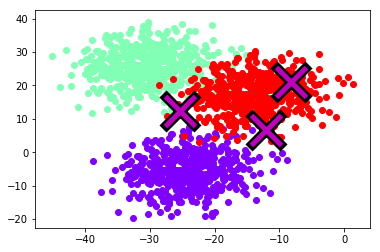

In [57]:
import tensorflow as tf
import numpy as np


n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70


data_centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)
nearest_indices = assign_to_nearest(samples, initial_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    
    for i in range(50):
        
        updated_centroid_value = session.run(updated_centroids)
        print(updated_centroid_value)

plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)